## Objective

The aim is to investigate the baseline model created in the previous notebook. Questions are : Is it learning the right parts? If it misclassifies a particular sample, what could be the reason? Sometimes, a model might be too good to be true, that is where explainability comes in.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Standard Imports

In [0]:
#!pip install innvestigate

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sys
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Run this if you are using google colab
sys.path.append('/content/drive/My Drive/')

from src.utils import *
from src.visualisation import *
from src.model import make_baseline_model

In [0]:
!unzip -q 'drive/My Drive/cell-images-for-detecting-malaria.zip'

# Create 'Combined' directory and copy all the png images over
# Note that the name 'Combined' must match that in the directory of the generator

!mkdir Combined 
!cp -a cell_images/cell_images/Parasitized/. Combined
!cp -a cell_images/cell_images/Uninfected/. Combined

## Reobtain the data and generators

In [0]:
# Read from the csv 
df_train = pd.read_csv('drive/My Drive/data/malaria_train_combined.csv')
df_val = pd.read_csv('drive/My Drive/data/malaria_val_combined.csv')
df_test = pd.read_csv('drive/My Drive/data/malaria_test_combined.csv')

df_train['labels'] = df_train['labels'].astype(str)
df_val['labels'] = df_val['labels'].astype(str)
df_test['labels'] = df_test['labels'].astype(str)

In [0]:
# Create generators manually
train_datagen = ImageDataGenerator(
     rescale=1./255,
     shear_range=0.2,
     zoom_range=0.2,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     horizontal_flip=True)
  
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Get the generators
train_gen, valid_gen, test_gen = fit_into_generators(df_train,df_val,df_test,train_datagen, val_datagen,batch_size=32)

Found 19291 validated image filenames belonging to 2 classes.
Found 6199 validated image filenames belonging to 2 classes.
Found 2068 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="train_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="val_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
# Reload baseline model
model = make_baseline_model()

model.load_weights('/content/drive/My Drive/weights/baseline_weights_for_predicting_malaria.h5')
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [12]:
model.evaluate_generator(test_gen)

[0.13494867413544331, 0.9550290134243624]

Indeed, this is the model that we have obtained from the previous training.

## Get confusion matrix 

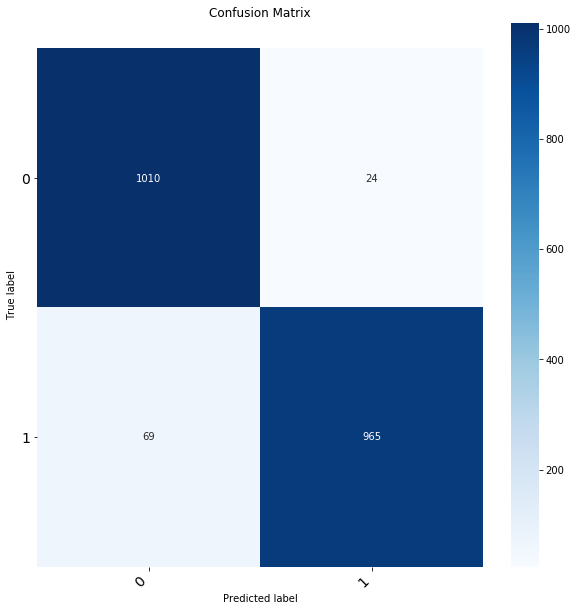

In [13]:
tp,tn,fp,fn = get_confusion_matrix(model,test_gen)

- 69 false negatives and 24 false positives
- We will identify the cases of true positives/ negatives
- Then, we will investigate the cases of false positives or false negatives to identify the sources of confusion

## Visualisation of 'Explainability' of trained baseline model 

In [0]:
#!pip install innvestigate

In [0]:
import imp
import innvestigate
import innvestigate.utils as iutils

imgnetutils = imp.load_source("utils_imagenet", "/content/drive/My Drive/src/utils_imagenet.py")

Three methods will be used for analysis. First is the gradient method, followed by the smoothgradient method and then the LRP Preset A Flat method. What these methods do is that they will take in trained model and a sample image and identify the 'parts' in the sample image that are most relevant for the prediction. By default, the prediction has the highest pre-softmax confidence will be analysed with respect to the most relevant parts.

In [0]:
# Define methods
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Function
    ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
    
    ("smoothgrad",            {"postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),

    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat")
]

In [0]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
  analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                          model_wo_softmax, # model without softmax output
                                          **method[1])      # optional analysis parameters
  analyzers.append(analyzer)

In [0]:
analyzer_names = ['Gradient', 'Smooth Gradient', 'LRP Preset A Flat']

### True positive samples 

In [0]:
# 4 random true positive samples
sample_indices = [np.random.choice(len(tp[0])) for i in range(4)]
print('The sample indices for true positives are {}'.format(sample_indices))


The sample indices for true positives are [852, 128, 768, 945]


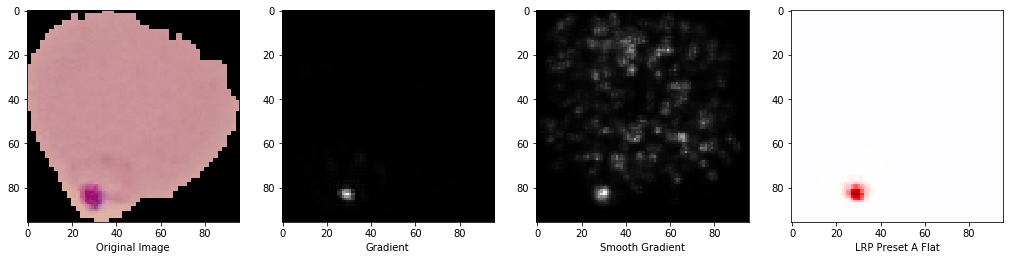

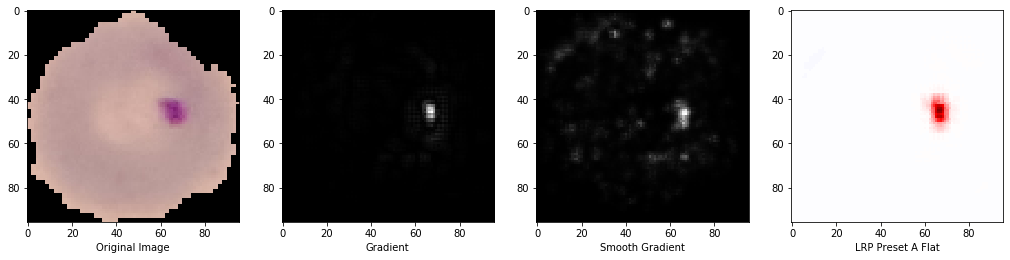

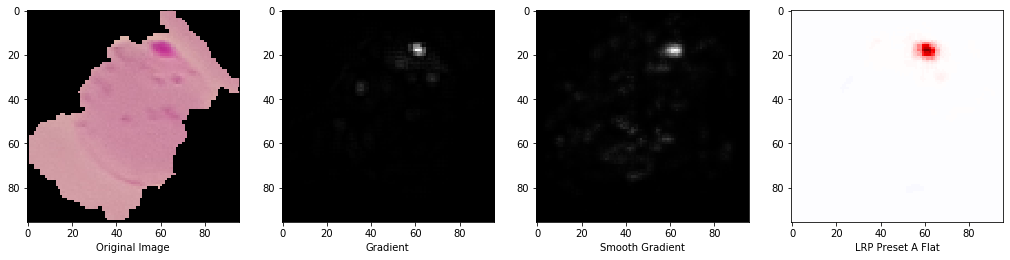

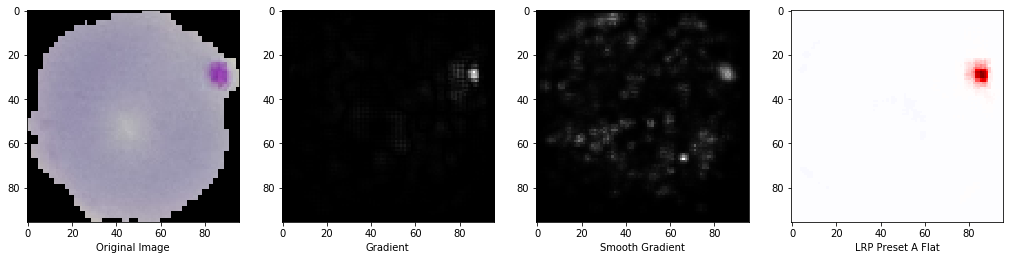

In [0]:
for image_index in sample_indices:
  show_explanation(tp[:,image_index,:,:,:],analyzers,analyzer_names,methods)

- It can be seen that for all 4 true positive random samples, the model has managed to 'learn' to focus on the pixels corresponding to the purple blobs as an association with 'Parasitized' cell, for all 3 gradient analysis methods. This is consistent with human interpretation.

### True Negative Samples

In [0]:
# 4 random true negative samples
sample_indices = [np.random.choice(len(tn[0])) for i in range(4)]
print('The sample indices for true negatives are {}'.format(sample_indices))


The sample indices for true negatives are [128, 202, 26, 397]


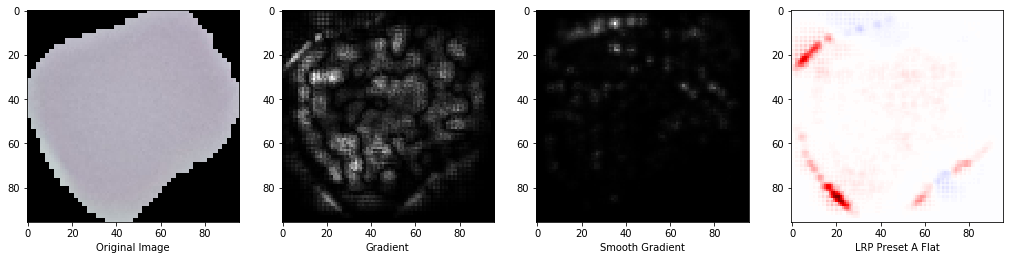

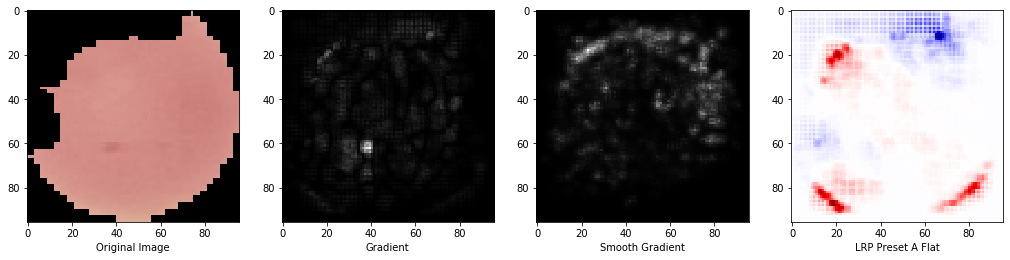

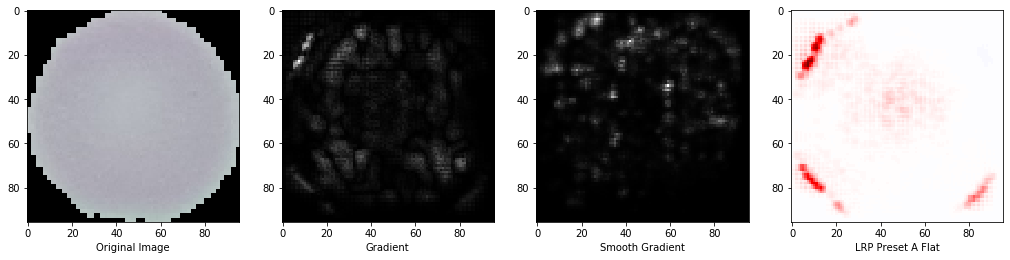

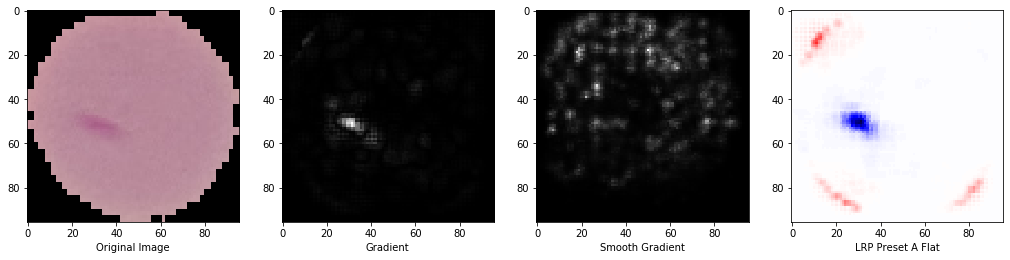

In [0]:
for image_index in sample_indices:
  show_explanation(tn[:,image_index,:,:,:],analyzers,analyzer_names,methods)

From a human's point of view, if there are no clear signs of 'purplish blobs' in the cell, then the cell is deemed to be unparasitized. However, based on the analysis methods, it seems that the model is using information from the pixels corresponding to the boundary of the cell to conclude on 'unparasitized', when it is expected for the gradient plots to show nothing i.e 'No regions of redness'. The question here is : Does the prediction of 'parasitized' or 'unparasitized' have something to do with the boundary? We will explore a few plots of 'parasitized' samples below from the training set.

Additionally, in the fourth sample, there are regions of 'blueness' in one of the analysis plots, which corresponds to negative contribution towards prediction of 'Unparasitized'. This means that the region undermines the confidence towards 'Unparasitized'. Upon closer scrutiny, there is a pale purplish blob in that region, which means that the model is less confident of unparasitized due to the presence of that blob. This is reasonable because a human can be equally confused as well!

In [0]:
# Plot a few samples of positive labels in training set

df_parasitized = df_train[df_train['labels'] == '1']
df_parasitized.reset_index(inplace=True)

In [0]:
# Choose 100 random samples of positive classes
sample_of_100_png = np.random.choice(df_parasitized['train_combined'],100)

In [0]:
samples_malaria = [plt.imread('cell_images/cell_images/Parasitized/' + png) for png in sample_of_100_png]

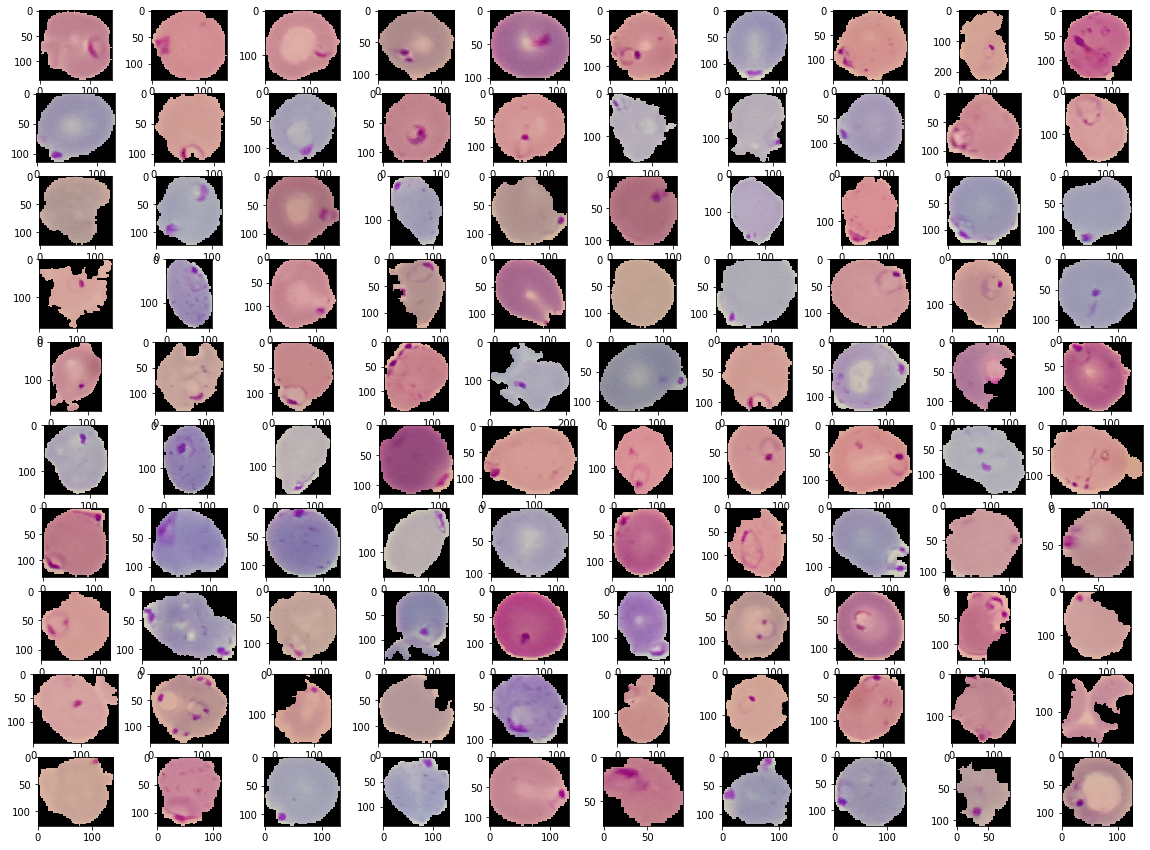

In [23]:
fig = plt.figure(figsize=(20,15))
for i in range(len(samples_malaria)):
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(samples_malaria[i])

Looking at the 100 random samples of postive classes, it seems that on average, most of the purple blobs occur near the boundary of the cell, hence it could be the reason why the model does the 'checking' at the boundaries for the 'purple blobs' to decide whether the cell is 'Parasitized' or 'Unparasitized. It could be that if the boundaries are clear, then the model will decide that the cell is 'Unparasitized'. The model in fact knows something that I dont!

## Cases where Model is confused

### False Positive

In [27]:
# 4 random false positive samples
sample_indices = [np.random.choice(len(fp[0])) for i in range(4)]
print('The sample indices for false positives are {}'.format(sample_indices))


The sample indices for false positives are [7, 20, 17, 9]


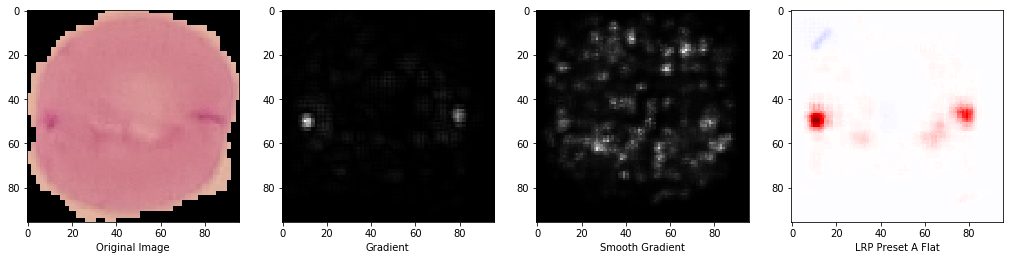

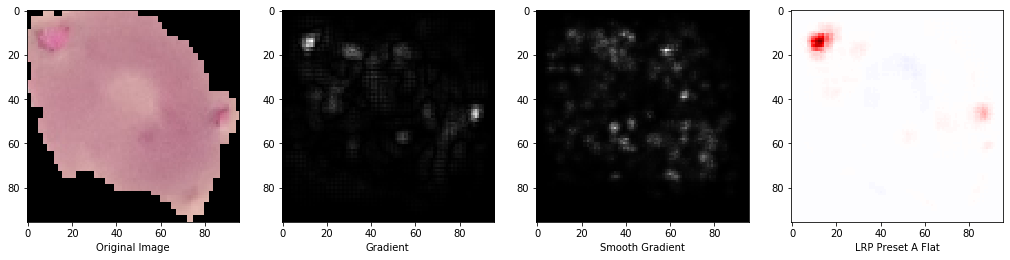

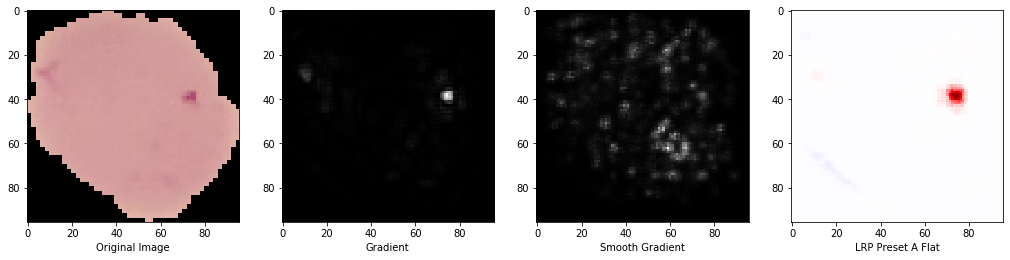

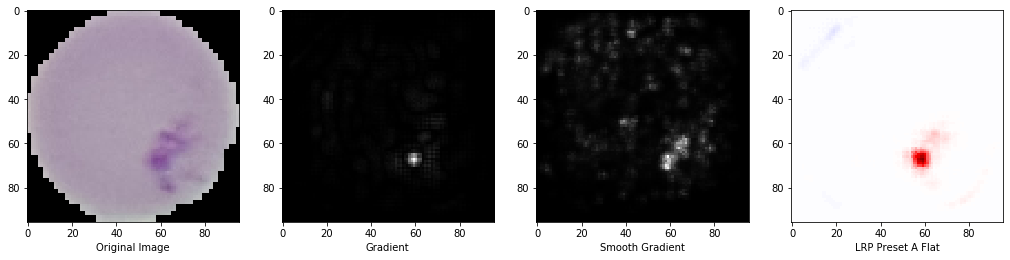

In [28]:
for image_index in sample_indices:
  show_explanation(fp[:,image_index,:,:,:],analyzers,analyzer_names,methods)

Apparently, the model is confused by the purple coloration within the cell to misclassify the negative classes as 'positive' classes. The fact is that there is a minimum color intensity or rather size, for the purple blobs to be classified as 'Parasitized'. The model might have failed to distinguish the color intensity or sizes. What could have been better done is to augment more of the images in the 'Unparasitized' cases via rotation and perhaps, we could have improved the performance if 'zooming' wasnt used in augmenting the data, since size of the 'blobs' might have been an important determinant in deciding whether the cell is 'Parasitized' or 'Unparasitized'

## False Negatives

In [39]:
# 4 random false negative samples
sample_indices = [np.random.choice(len(fn[0])) for i in range(4)]
print('The sample indices for false negatives are {}'.format(sample_indices))

The sample indices for false negatives are [58, 66, 44, 66]


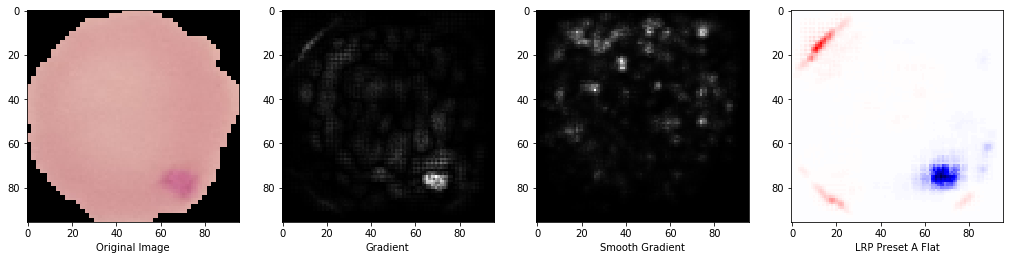

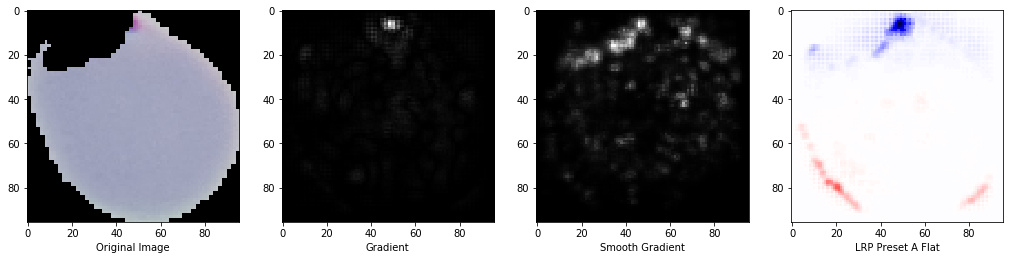

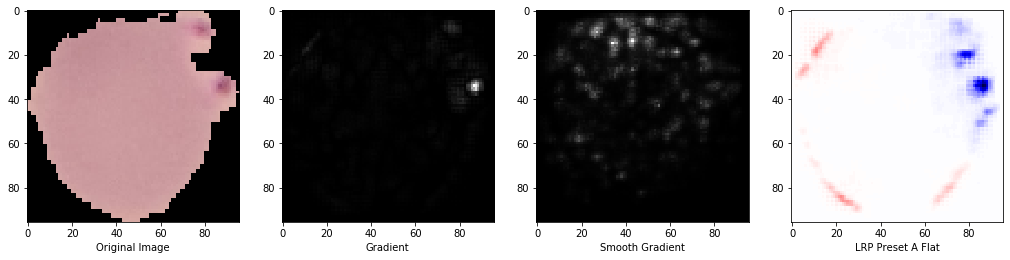

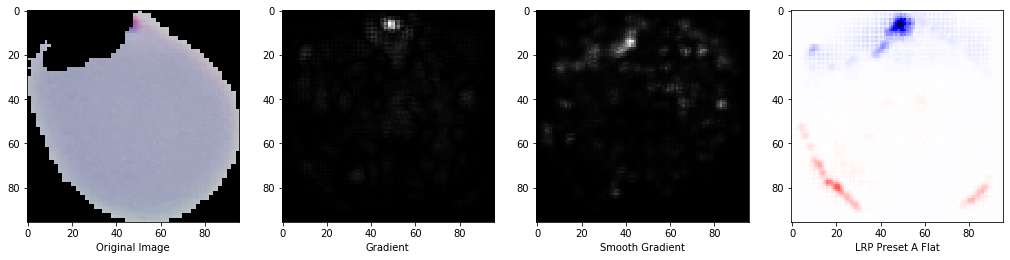

In [40]:
for image_index in sample_indices:
  show_explanation(fn[:,image_index,:,:,:],analyzers,analyzer_names,methods)

Based on the false negative samples, it seems that the model only 'looks' at the boundary to make a conclusion that the cell is 'Unparasitized' when it is in fact 'Parasitized'. It seems to have placed more emphasis on checking the boundary, similar to the true negative cases. However, a point of optimism is that it has somehow recognised the pixels corresponding to the purplish blobs as negative weightage towards 'Unparasitized', just that it could have been more confident towards the right prediction. (Indicated by the blue regions in the LRP Preset A Flat heatmap)